In [1]:
# default_exp ml.model

# ML model

> ML model definition and helper functions.

In [2]:
#export
from expoco.core import *
from pathlib import Path
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import json

## Saving model state

In [4]:
#export
def save_state_dict(path, state_dict, **training_info):
    "Saves `state_dict` and `training_info` to a new model directory"
    model_id = now()
    output_path = path/f'model_{model_id}'
    output_path.mkdir()
    log = LogFile(output_path/'model.log')
    log('output_path:', output_path.resolve())
    log('training_info:', training_info)
    file_name = output_path/'state_dict.npz'
    log('file_name:', file_name)
    np.savez(file_name, **{k:state_dict[k].detach().cpu().numpy() for k in state_dict})
    np.load(file_name) # check that we didn't need to pickle

- `path` directory to create the new model directory in
    - usually, this will be processed data directory; e.g. `data/viseme_dataset_20211019_202836/processed_20211019_205023`
    - which would create something like `data/viseme_dataset_20211019_202836/processed_20211019_205023/model_20211020_193549`
- `state_dict` a pytorch state_dict - i.e. a dictionary of tensors
- `training_info` any info needed to repeat the model training (can also include model metrics etc)

## Loading model state

In [5]:
#export
def load_state_dict(path):
    "Load `state_dict.npz` from `path` (a model directory)"
    return np.load(Path(path)/'state_dict.npz')

# Inference only `numpy` model

We need to write a little code so that we can run inference using a previously saved state dict.

In [6]:
#export 
class NpBatchNorm1d:
    "Applies Batch Normalization"
    # https://github.com/pytorch/pytorch/blob/420b37f3c67950ed93cd8aa7a12e673fcfc5567b/aten/src/ATen/native/Normalization.cpp#L61-L126
    def __init__(self, weight, bias, running_mean, running_var, num_batches_tracked=None):
        self.weight, self.bias = weight, bias
        self.running_mean, self.running_std = running_mean, np.sqrt(running_var + 1e-5)
    def __call__(self, x):
        x = x - self.running_mean
        x = x / self.running_std
        x = x * self.weight
        x = x + self.bias
        return x

In [7]:
#export 
class NpLinear:
    "Applies a linear transformation"
    def __init__(self, weight, bias=None):
        self.weight, self.bias = weight.T, bias
    def __call__(self, x):
        x = x @ self.weight
        if self.bias is not None:
            x = x + self.bias
        return x

In [8]:
#export 
class NpReLU:
    "Applies element wise max of x and zero"
    def __call__(self, x):
        return np.maximum(x, 0)

In [9]:
#export 
class NpModel:
    "A sequential module container"
    def __init__(self, *modules):
        self.modules = modules
    def __call__(self, x):
        for module in self.modules:
            x = module(x)
        return x

In [10]:
#export
def get_class_count(model):
    return model.modules[-1].weight.shape[1]

In [11]:
#export
def load_tabular_model(path):
    "Load `state_dict.npz` from `path` (a model directory) and create a tabular model"
    state_dict = load_state_dict(path)
    # TODO: this only works for the model config we used ... make it a bit more generic
    return NpModel(NpBatchNorm1d(**get_dict_subset(state_dict, 'bn_cont')),
                   NpLinear(**get_dict_subset(state_dict, 'layers.0.0')),
                   NpReLU(),
                   NpBatchNorm1d(**get_dict_subset(state_dict, 'layers.0.2')),
                   NpLinear(**get_dict_subset(state_dict, 'layers.1.0')),
                   NpReLU(),
                   NpBatchNorm1d(**get_dict_subset(state_dict, 'layers.1.2')),
                   NpLinear(**get_dict_subset(state_dict, 'layers.2.0')))

In [12]:
np_model = load_tabular_model('data/viseme_dataset_20211019_202836/processed_20211019_205023/model_20211020_193549')
assert 4 == get_class_count(np_model)

In [13]:
#export 
def create_confusion_matrix(model, df, cont_names, y_name):
    "Confusion matrix as a numpy array"
    class_count = get_class_count(model)
    confusion_matrix = np.zeros([class_count,class_count], dtype=int)
    output = model(df[cont_names].to_numpy())
    preds = np.argmax(output, axis=1)
    targets = df[y_name].to_numpy()
    for p,t in zip(preds, targets):
        confusion_matrix[t][p]+=1
    return confusion_matrix

In [14]:
path = Path('data/viseme_dataset_20211019_202836/processed_20211019_205023')
df = pd.read_csv(path/'data.csv')
confusion_matrix = create_confusion_matrix(np_model, df, df.columns[:-1], df.columns[-1])
confusion_matrix

array([[4443,   15,   17,   25],
       [   6, 2493,    0,    1],
       [  12,    0, 2463,   25],
       [   1,    1,   34, 2464]])

In [15]:
#export
def plot_confusion_matrix(model, df, cont_names, y_name):
    "Plot a confusion matrix using matplotlib"
    confusion_matrix = create_confusion_matrix(model, df, cont_names, y_name)
    class_count = get_class_count(model) # class_count might not be the same as len(class_ids)
    class_ids, class_labels = VisemeConfig().get_class_ids_and_labels()
    fig, ax = plt.subplots(figsize=(9,9))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.8)
    # ax.xaxis.set_ticks_position('bottom') # must be after matshow
    ax.yaxis.set_label_position('right')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    tick_marks = np.arange(class_count)
    plt.xticks(tick_marks, class_labels[:class_count], rotation=90)
    plt.yticks(tick_marks, class_labels[:class_count], rotation=0)
    plt.show()

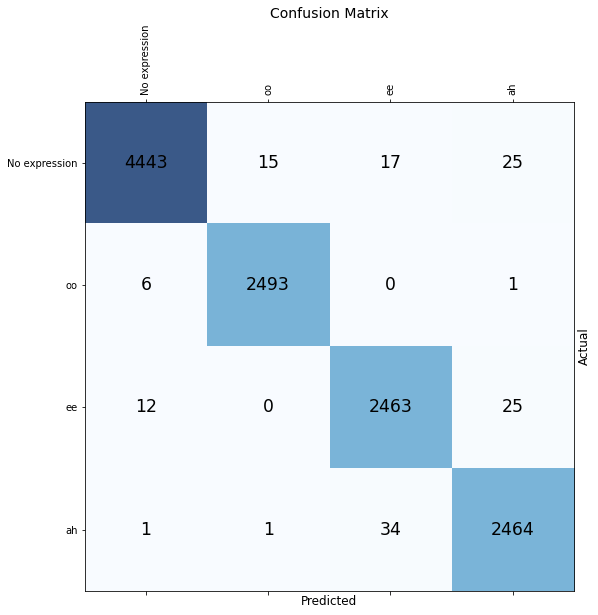

In [16]:
plot_confusion_matrix(np_model, df, df.columns[:-1], df.columns[-1])

In [17]:
#export 
def get_idxs_of_interest(model, df, cont_names, y_name, target_of_interest, pred_of_interest):
    "Indeces in `df` where `df[y_name]` had `target_of_interest` but the model predicted `pred_of_interest`"
    viseme_config = VisemeConfig()
    output = model(df[cont_names].to_numpy())
    preds = np.argmax(output, axis=1)
    targets = df[y_name].to_numpy()
    idxs = []
    print('target_of_interest', viseme_config.get_class_label(target_of_interest),
          'pred_of_interest', viseme_config.get_class_label(pred_of_interest))
    print('overall accuracy', (targets==preds).sum() / len(targets))
    _filter = targets==target_of_interest
    print('accuracy for target_of_interest',(targets[_filter]==preds[_filter]).sum() / _filter.sum())
    for i, (p,t) in enumerate(zip(preds,targets)):
        if t==target_of_interest and p==pred_of_interest:
            idxs.append(i)
    return idxs


- `target_of_interest` class ID of the target we're interested in
- `pred_of_interest` class ID of the prediction we're interested in

In [18]:
idxs = get_idxs_of_interest(np_model, df, df.columns[:-1], df.columns[-1], 0, 2)

target_of_interest No expression pred_of_interest ee
overall accuracy 0.9885833333333334
accuracy for target_of_interest 0.9873333333333333


We can `df.iloc[idxs]` and look at the rows that the model saw.

We can also use these indexes on the "raw" data &darr; which gives us access to `img_path`, input values before processing etc

In [19]:
pd.read_csv(path.parent/'data.csv').iloc[idxs]

,img_path,0x,0y,0z,1x,1y,1z,2x,2y,2z,...,465x,465y,465z,466x,466y,466z,467x,467y,467z,expression_id
4207,NaN,0.552906,0.619325,-0.034688,0.560797,0.561092,-0.059172,0.553599,0.580485,-0.032871,...,0.559876,0.468488,0.000885,0.611032,0.457979,0.037785,0.616293,0.449680,0.039954,4
4208,NaN,0.553516,0.615186,-0.034862,0.561990,0.557302,-0.061037,0.554363,0.576913,-0.034116,...,0.559729,0.466894,-0.000321,0.610426,0.457018,0.037223,0.615548,0.448617,0.039500,4
4209,20211014132331_210.png,0.548624,0.611900,-0.035471,0.556068,0.554740,-0.060681,0.549466,0.574503,-0.034080,...,0.557108,0.467183,-0.000030,0.610174,0.456798,0.035527,0.615634,0.448335,0.037623,4
4210,NaN,0.551055,0.618978,-0.034729,0.559361,0.558681,-0.060977,0.551980,0.578582,-0.033698,...,0.557748,0.466747,0.000054,0.609709,0.455966,0.037737,0.614848,0.447821,0.039897,4
4211,NaN,0.550630,0.618022,-0.037818,0.558278,0.556195,-0.061059,0.551047,0.577372,-0.034743,...,0.556913,0.466240,0.003534,0.608549,0.457229,0.042443,0.613725,0.449546,0.044718,4
4594,NaN,0.481825,0.651761,-0.031967,0.481543,0.593311,-0.064179,0.480637,0.609249,-0.032714,...,0.496317,0.484431,-0.009585,0.561585,0.465392,0.015208,0.567391,0.457150,0.015832,4
9521,NaN,0.408673,0.646001,-0.033405,0.401676,0.585434,-0.064072,0.406232,0.603256,-0.033400,...,0.426726,0.481221,-0.011281,0.498653,0.460446,0.002888,0.505413,0.451269,0.002735,4
9525,NaN,0.426657,0.654123,-0.031315,0.421783,0.593845,-0.063981,0.424661,0.610969,-0.032482,...,0.443398,0.486072,-0.012106,0.513103,0.466690,0.005579,0.519363,0.458144,0.005683,4
9527,NaN,0.435851,0.654072,-0.031958,0.432464,0.593230,-0.064405,0.434229,0.610760,-0.032937,...,0.452220,0.486179,-0.011008,0.521035,0.467404,0.008754,0.527246,0.458906,0.009022,4
9529,20211014143006_30.png,0.444400,0.659957,-0.031179,0.442198,0.599247,-0.063935,0.443186,0.616371,-0.032597,...,0.460798,0.489374,-0.010942,0.528684,0.471192,0.009494,0.534739,0.462270,0.009857,4


In [21]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 05a_ml_data.ipynb.
Converted 05b_ml_model.ipynb.
Converted 10a_mediapipe_face_mesh_identify_landmarks.ipynb.
Converted 10b_mediapipe_face_mesh_to_viseme_dataset.ipynb.
Converted 10c_mediapipe_face_mesh_train_model.ipynb.
Converted 10d_test_np_model.ipynb.
Converted index.ipynb.
Converted project_lifecycle.ipynb.
